In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score,KFold

import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings('ignore')

from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt.pyll.stochastic import sample

from sklearn.metrics import recall_score, precision_score


path = "/home/steve/Desktop/challenge1_HowCrispCanYouClassify/data/"
train_data = pd.read_csv(path+"iris_train.csv")
test_data = pd.read_csv(path+"iris_test.csv")
train_data.head()

/home/steve/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Unnamed: 0,0,1,2,3,labels
0,0,6.3,2.9,5.6,1.8,Iris-virginica
1,1,5.6,3.0,4.5,1.5,Iris-versicolor
2,2,7.9,3.8,6.4,2.0,Iris-virginica
3,3,6.5,2.8,4.6,1.5,Iris-versicolor
4,4,5.0,2.0,3.5,1.0,Iris-versicolor


In [2]:
train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
train_data.columns

Index(['0', '1', '2', '3', 'labels'], dtype='object')

In [3]:
test_data.drop(['Unnamed: 0'], axis=1, inplace=True)
test_data.head()

,0,1,2,3
0,7.2,3.6,6.1,2.5
1,4.7,3.2,1.3,0.2
2,4.4,3.2,1.3,0.2
3,4.5,2.3,1.3,0.3
4,6.4,3.2,4.5,1.5


In [4]:
#fe: NAN, correlations(feature importance), scatter, outliers, categories(pcuts), skeness/kurtosis
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 5 columns):
0         110 non-null float64
1         110 non-null float64
2         110 non-null float64
3         110 non-null float64
labels    110 non-null object
dtypes: float64(4), object(1)
memory usage: 4.4+ KB


In [5]:
"""
tr = [x for x in range(len(train_data)) if x % 4!= 0 ]
te = [x for x in range(len(train_data)) if x % 4== 0]

train = train_data.loc[tr]
test = train_data.loc[te]
"""
train = train_data.copy()
test = test_data.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = np.array(train['labels'])
le.fit(labels)
labels = le.transform(labels)
labels[0:5]

array([2, 1, 2, 1, 1])

In [7]:
train['labels'] = labels
train.head()

,0,1,2,3,labels
0,6.3,2.9,5.6,1.8,2
1,5.6,3.0,4.5,1.5,1
2,7.9,3.8,6.4,2.0,2
3,6.5,2.8,4.6,1.5,1
4,5.0,2.0,3.5,1.0,1


In [8]:
y_train = train['labels'].ravel()
train = train.drop(['labels'], axis=1)
x_train = train #train.values
train.head()

,0,1,2,3
0,6.3,2.9,5.6,1.8
1,5.6,3.0,4.5,1.5
2,7.9,3.8,6.4,2.0
3,6.5,2.8,4.6,1.5
4,5.0,2.0,3.5,1.0


In [9]:
"""
y_test = test['labels'].ravel()
test = test.drop(['labels'], axis=1)
x_test = test.values
"""
x_test = test  #test.values
print("Both shape train:{0} and {1}".format(x_train.shape, x_test.shape))


Both shape train:(110, 4) and (40, 4)


In [10]:
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
print("the ntrain size is {0} and ntest size is {1}".format(ntrain, ntest))

the ntrain size is 110 and ntest size is 40


In [11]:
from sklearn.cross_validation import KFold

SEED = 5
NFOLDS = 10
kf = KFold(len(train), n_folds=NFOLDS, random_state=SEED, shuffle=True)
kf

sklearn.cross_validation.KFold(n=110, n_folds=10, shuffle=True, random_state=5)

In [12]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        
        if 'random_state' in params:
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return self.clf.fit(x,y).feature_importances_
    
class XgbHelper(object):
    def __init__(self, seed=SEED, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)
        
    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gdbt = xgb.train(self.param, dtrain, self.nrounds)
        
    def predict(self, x):
        return self.gdbt.predict(xgb.DMatrix(x))

In [13]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    
    list_vals = oof_test_skf.mean(axis=0)
    oof_test[:] = [round(x, 0) for x in list_vals]
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


In [14]:
#PARAMETER TUNING
def hyperopt_train(params):
    hclf = ExtraTreesClassifier(**params)
    hscores = cross_val_score(hclf, x_train, y_train, cv=2)
    return hscores.mean()
space = {
    'max_depth': hp.choice('max_depth', range(1,10)), 
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0,0.5),
    'min_samples_split': hp.choice('min_samples_split', range(2, 10)), 
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0,0.5), 
            
          }
def f(params):
    acc = hyperopt_train(params)
    return {'loss': -acc, 'status':STATUS_OK}
    
trials = Trials()
hbest = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)

print(hbest)

{'max_depth': 3, 'min_samples_leaf': 0.08772033821883873, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.004899046512516991}


In [15]:
#min_samples_leaf:3, min_samples_split:2, min_weight_fraction_leaf:0.1917
rf_params = {
    'n_estimators': 500,
    'max_features' : 'sqrt',
    
}

#max_depth: 4, min_samples_leaf:0.047959, min_samples_split:4, min_weight_fraction_leaf:0.0959
et_params = {
    'n_estimators':500
}

#*****

#min_samples_leaf:2, min_samples_split:2, minweight_fraction_leaf:0.05369
gb_params = {
    'n_estimators': 500
}

#C:0.4659, gamma:3.0503, kernel: linear
svc_params = {
    'kernel' : 'linear',
    'C' : 0.4659,
    }
#base_score: 0.5965, min_child_weight: 2
xgb_params = {
     'objective':'multi:softmax', 
    'num_class':3, 
    'base_score': 0.5965, 
    'min_child_weight': 2
    
     }
#leaf_size=2, n_neighbors: 6
kn_params = {
    'n_neighbors': 2, 
    'leaf_size': 8, 
    'p':2
}


In [16]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)

gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
kn = SklearnHelper(clf=KNeighborsClassifier, params=kn_params)

xg = XgbHelper(seed=SEED, params=xgb_params)


In [17]:
rf_feature = rf.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)

cols = train.columns.values
features_df = pd.DataFrame({
    'features': cols, 
    'Random Forest': rf_feature,
    'Gradient Boost': gb_feature, 
    'Extra Trees': et_feature    
})
features_df['Mean'] = features_df.mean(axis=1)
features_df

,Extra Trees,Gradient Boost,Random Forest,features,Mean
0,0.095439,0.008065,0.080252,0,0.061252
1,0.063091,0.016833,0.032956,1,0.037627
2,0.385626,0.072280,0.422877,2,0.293594
3,0.455843,0.056822,0.463914,3,0.325527


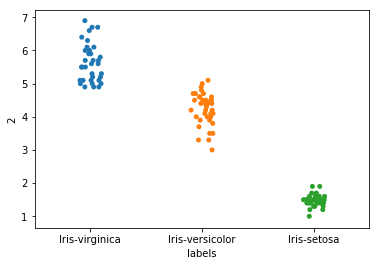

In [18]:
sns.stripplot(train_data['labels'], train_data['2'], jitter=True)

In [19]:
ftwo = max(train_data[train_data['labels']=='Iris-setosa']['2'])
fthree = max(train_data.loc[train_data['labels']=='Iris-setosa']['3'].values)
ftwo

1.8999999999999999

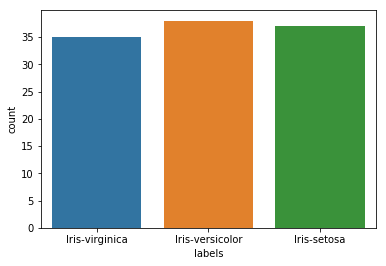

In [20]:
sns.countplot(x='labels', data=train_data)

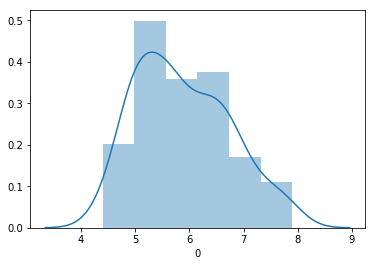

In [21]:
sns.distplot(train_data['0'], kde=True)

In [22]:
print("Column 4 skewnes is: {}".format(train_data['3'].skew()))
print("Column 1 skewnes is: {}".format(train_data['0'].skew()))
#corrected = np.log1p(train_data['3'])    #skew > 0.75

Column 4 skewnes is: -0.09000475821285771
Column 1 skewnes is: 0.4458922507290206


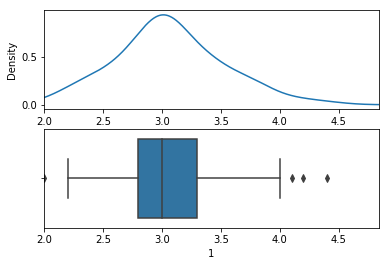

In [23]:
#Outliers
pcol = '1'
plt.subplot(211)
plt.xlim(train_data[pcol].min(), train_data[pcol].max()*1.1)
ax = train_data[pcol].plot(kind='kde')

plt.subplot(212)
plt.xlim(train_data[pcol].min(), train_data[pcol].max()*1.1)
sns.boxplot(x=train_data[pcol])

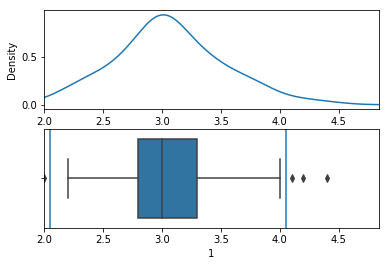

In [24]:
#Tukeys outlier detection
pcol = '1'
q75, q25 = np.percentile(train_data[pcol], [25,74])
iqr = q75 - q25
lower_bound = q25 - iqr*1.5
upper_bound = q75 + iqr*1.5



plt.subplot(211)
plt.xlim(train_data[pcol].min(), train_data[pcol].max()*1.1)
ax = train_data[pcol].plot(kind='kde')

plt.subplot(212)
plt.xlim(train_data[pcol].min(), train_data[pcol].max()*1.1)
sns.boxplot(x=train_data[pcol])

plt.axvline(x=lower_bound)
plt.axvline(x=upper_bound)

In [25]:
def column_outliers(df, col):
    vals = []
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr * 1.5
    upper_bound = q3 + iqr * 1.5
    for x in df[col].values:
        if (x < lower_bound) | (x > upper_bound):
            vals.append(1)
        else:
            vals.append(0)
    return vals



In [26]:
y_t = y_train.copy()
x_t = train_data.copy()

x_t['labels'] = y_t
x_t.corr()

,0,1,2,3,labels
0,1.000000,-0.126670,0.869571,0.821253,0.791717
1,-0.126670,1.000000,-0.454436,-0.409021,-0.448478
2,0.869571,-0.454436,1.000000,0.966611,0.951561
3,0.821253,-0.409021,0.966611,1.000000,0.962553
labels,0.791717,-0.448478,0.951561,0.962553,1.000000


labels    1.000000
3         0.962553
2         0.951561
0         0.791717
1        -0.448478
Name: labels, dtype: float64


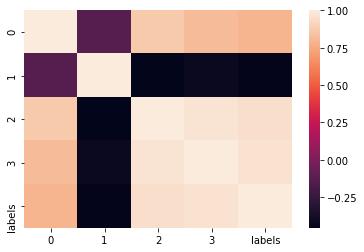

In [27]:
corr = x_t.corr()
print(corr['labels'].sort_values(ascending=False))

sns.heatmap(corr)

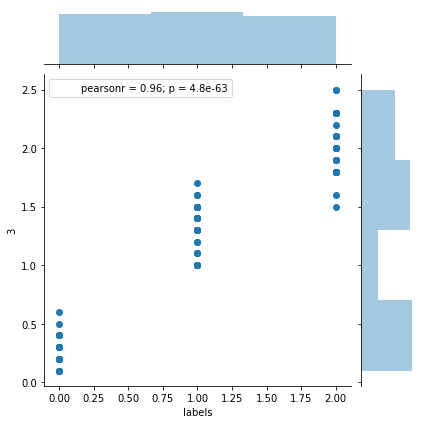

In [28]:
sns.jointplot(x=x_t['labels'], y=x_t['3'])

In [29]:
#FE: nans, correlations, new categories (qcuts), scatters,
#new columns scatters(+-*/), outliers, skeweness, kurtosis
#while adding/removing columns merges train & test, 
#while adding/removing rows separate train & test,

merged = pd.concat([x_train, x_test], axis=0)
borders = len(x_train)
merged.shape

(150, 4)

In [30]:
merged['setosa'] = [0.0]*merged.shape[0]
merged['setosa'].loc[(merged['3'] <= 0.6) | (merged['2'] < 2)]=1

In [31]:
col2_outliers = column_outliers(merged, '1')
merged['col2_outliers'] = col2_outliers
merged.head()

,0,1,2,3,setosa,col2_outliers
0,6.3,2.9,5.6,1.8,0.0,0
1,5.6,3.0,4.5,1.5,0.0,0
2,7.9,3.8,6.4,2.0,0.0,0
3,6.5,2.8,4.6,1.5,0.0,0
4,5.0,2.0,3.5,1.0,0.0,1


In [32]:
corrected = np.log1p(merged['1'])
merged['logcol2'] = corrected
merged.head()

,0,1,2,3,setosa,col2_outliers,logcol2
0,6.3,2.9,5.6,1.8,0.0,0,1.360977
1,5.6,3.0,4.5,1.5,0.0,0,1.386294
2,7.9,3.8,6.4,2.0,0.0,0,1.568616
3,6.5,2.8,4.6,1.5,0.0,0,1.335001
4,5.0,2.0,3.5,1.0,0.0,1,1.098612


In [33]:
merged['cat_col1'] = pd.qcut(merged['1'], q=4, labels=False)

In [34]:
#Desperate attempt
merged['col1+2'] = merged['0']+merged['1']
merged['col1*2'] = merged['0']*merged['1']
merged.head()

,0,1,2,3,setosa,col2_outliers,logcol2,cat_col1,col1+2,col1*2
0,6.3,2.9,5.6,1.8,0.0,0,1.360977,1,9.2,18.27
1,5.6,3.0,4.5,1.5,0.0,0,1.386294,1,8.6,16.80
2,7.9,3.8,6.4,2.0,0.0,0,1.568616,3,11.7,30.02
3,6.5,2.8,4.6,1.5,0.0,0,1.335001,0,9.3,18.20
4,5.0,2.0,3.5,1.0,0.0,1,1.098612,0,7.0,10.00


In [35]:
x_train = merged[:borders].values
x_test = merged[borders:].values

In [36]:

et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest

gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier
kn_oof_train, kn_oof_test = get_oof(kn, x_train, y_train, x_test)

xg_oof_train, xg_oof_test = get_oof(xg, x_train, y_train, x_test)
print("Training is complete")


Training is complete


In [37]:
"""
print("et:{}".format(accuracy_score(y_test, et_oof_test)))
print("rf:{}".format(accuracy_score(y_test, rf_oof_test)))
print("gb:{}".format(accuracy_score(y_test, gb_oof_test)))
print("svc:{}".format(accuracy_score(y_test, svc_oof_test)))
print("knn:{}".format(accuracy_score(y_test, kn_oof_test)))
print("xg:{}".format(accuracy_score(y_test, xg_oof_test)))
"""


'\nprint("et:{}".format(accuracy_score(y_test, et_oof_test)))\nprint("rf:{}".format(accuracy_score(y_test, rf_oof_test)))\nprint("gb:{}".format(accuracy_score(y_test, gb_oof_test)))\nprint("svc:{}".format(accuracy_score(y_test, svc_oof_test)))\nprint("knn:{}".format(accuracy_score(y_test, kn_oof_test)))\nprint("xg:{}".format(accuracy_score(y_test, xg_oof_test)))\n'

In [38]:
#f1_score(y_test, svc_oof_test, average="weighted")

In [39]:
#from sklearn.metrics import recall_score, precision_score
#precision_score(y_test, svc_oof_test, average="weighted")

In [40]:
#STACKING         ensembling/averaging preds

x_trained = np.concatenate((svc_oof_train,kn_oof_train,et_oof_train, 
            rf_oof_train, gb_oof_train),axis=1)
x_tested = np.concatenate((svc_oof_test,kn_oof_test,et_oof_test, rf_oof_test, gb_oof_test), axis=1)
len(x_tested)

40

In [41]:
stacked = xgb.XGBClassifier(n_estimators=10000, objective='multi:softmax').fit(x_trained, y_train)
predictions = stacked.predict(x_tested)
#accuracy_score(y_test, predictions)

In [42]:
predictions = le.inverse_transform(predictions)
predictions[0:3]

array(['Iris-virginica', 'Iris-setosa', 'Iris-setosa'], dtype=object)

In [43]:
ids = [x for x in range(0, test_data.shape[0])]
iris_test_labelled = pd.DataFrame({'id': ids, 
                'labels': predictions})
iris_test_labelled.head()

,id,labels
0,0,Iris-virginica
1,1,Iris-setosa
2,2,Iris-setosa
3,3,Iris-setosa
4,4,Iris-versicolor


In [44]:
iris_test_labelled.to_csv(path+'iris_test_labelled.csv')


In [45]:
#precision_score(y_test, predictions, average="weighted")

In [46]:
#f1_score(y_test, predictions, average="weighted")